# What drives the price of a car?


### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

**Data Problem Definition:**

The business objective is to determine what features of a used car are the strongest predictors of its listing price. Technically, this is a **supervised regression problem** where the target variable is `price` (continuous) and the features include vehicle attributes such as year, manufacturer, condition, mileage (odometer), fuel type, transmission, and others.

Our goal is to build interpretable regression models that:
1. Accurately predict used car prices based on vehicle attributes.
2. Identify which features have the largest positive or negative effect on price.
3. Quantify the magnitude of these effects so the dealership can make data-driven inventory decisions.

We will use **Mean Squared Error (MSE)** and **R² score** as our primary evaluation metrics. MSE penalizes large prediction errors (important when prices vary widely), and R² tells us what proportion of price variance our model explains. These are standard for regression tasks and will allow us to compare models objectively.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load the dataset
df = pd.read_csv('data/vehicles.csv')
print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
df.head()

Dataset shape: 426,880 rows x 18 columns


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Steps to understand the data:**

1. **Examine shape, data types, and missing values** — Identify which columns have significant gaps.
2. **Descriptive statistics** — Look at distributions of numeric variables (price, year, odometer).
3. **Categorical value counts** — Understand the composition of features like manufacturer, fuel, condition, etc.
4. **Identify quality issues** — Price outliers (e.g., $0 or billions), unrealistic odometer readings, missing data patterns.
5. **Visualize distributions** — Histograms for continuous variables, bar plots for categorical ones.
6. **Explore relationships** — Scatter plots and box plots of features vs. price.

In [3]:
# Quick overview of data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# Descriptive statistics for numeric columns
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

,Missing Count,Missing %
size,306361,71.8
cylinders,177678,41.6
condition,174104,40.8
VIN,161042,37.7
drive,130567,30.6
paint_color,130203,30.5
type,92858,21.8
manufacturer,17646,4.1
title_status,8242,1.9
model,5277,1.2


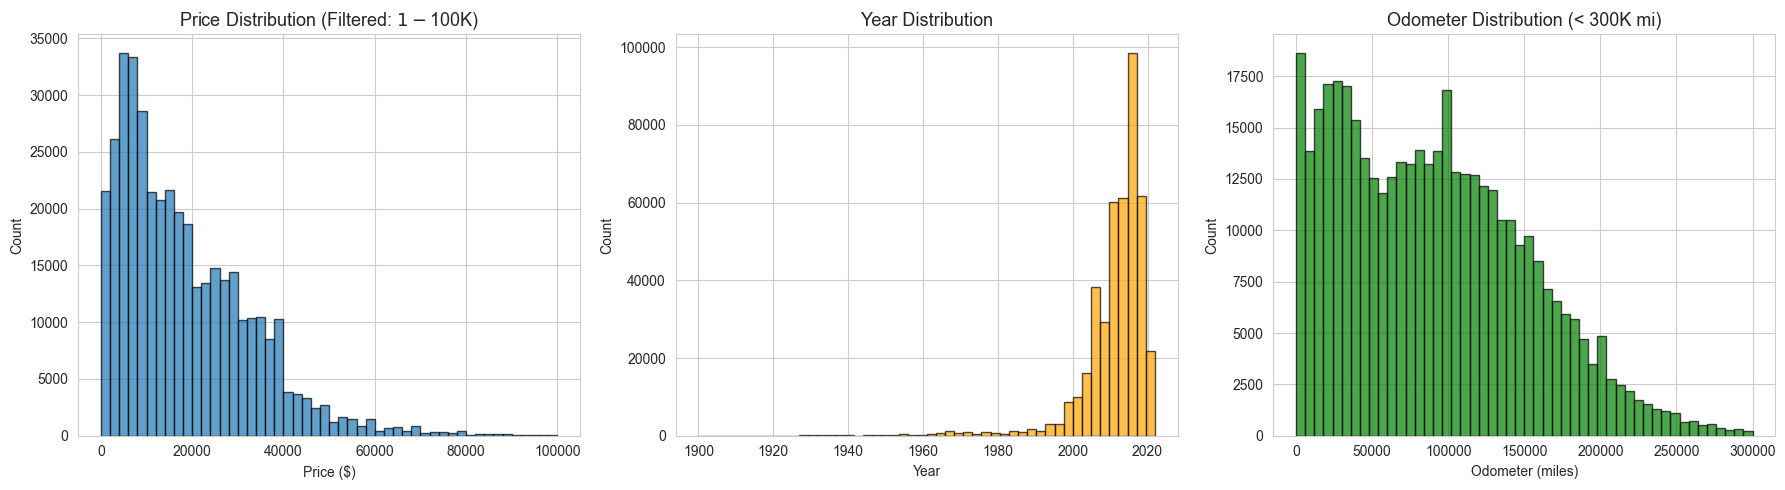

Price = $0: 32,895 rows
Price > $100K: 655 rows
Odometer > 500K: 1,386 rows


In [6]:
# Visualize distributions of key numeric features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Price distribution (filtered for readability)
axes[0].hist(df['price'][(df['price'] > 0) & (df['price'] < 100_000)], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Price Distribution (Filtered: $1-$100K)', fontsize=13)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Count')

# Year distribution
axes[1].hist(df['year'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Year Distribution', fontsize=13)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')

# Odometer distribution
axes[2].hist(df['odometer'][(df['odometer'] > 0) & (df['odometer'] < 300_000)].dropna(), 
             bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Odometer Distribution (< 300K mi)', fontsize=13)
axes[2].set_xlabel('Odometer (miles)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Price = $0: {(df['price'] == 0).sum():,} rows")
print(f"Price > $100K: {(df['price'] > 100_000).sum():,} rows")
print(f"Odometer > 500K: {(df['odometer'] > 500_000).sum():,} rows")

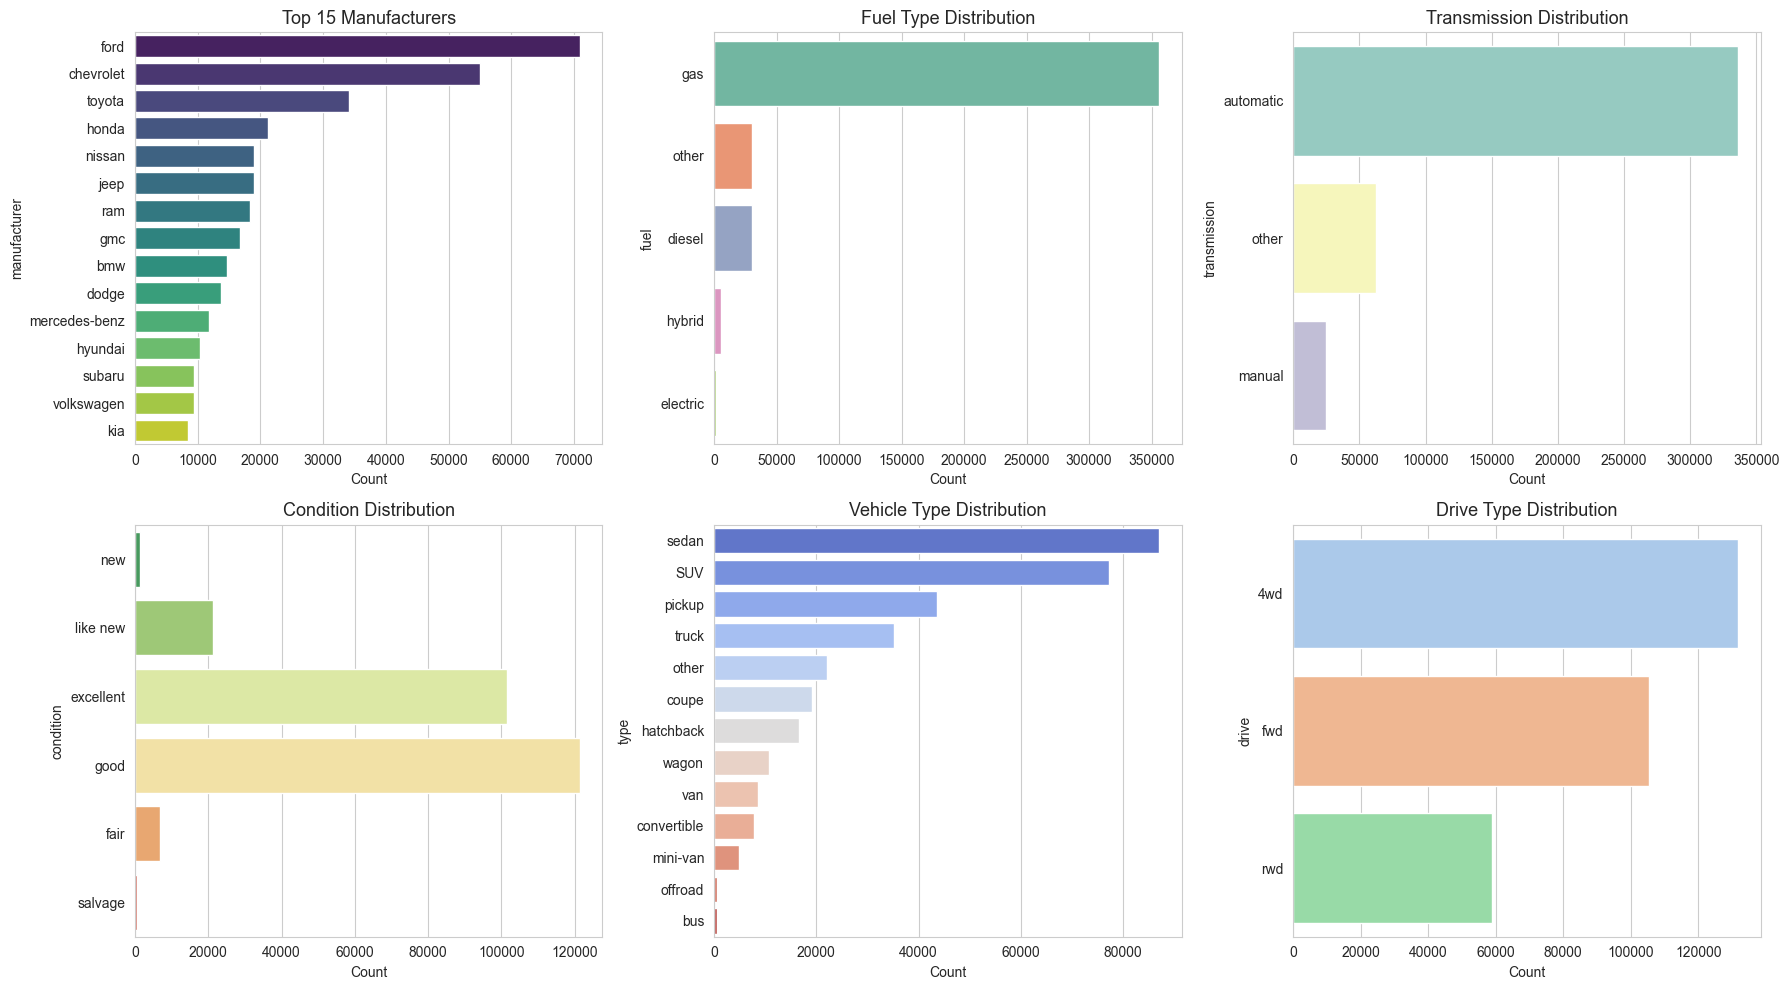

In [7]:
# Categorical feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

top_mfr = df['manufacturer'].value_counts().head(15)
sns.barplot(x=top_mfr.values, y=top_mfr.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 15 Manufacturers', fontsize=13)
axes[0, 0].set_xlabel('Count')

sns.countplot(data=df, y='fuel', ax=axes[0, 1], order=df['fuel'].value_counts().index, palette='Set2')
axes[0, 1].set_title('Fuel Type Distribution', fontsize=13)
axes[0, 1].set_xlabel('Count')

sns.countplot(data=df, y='transmission', ax=axes[0, 2], order=df['transmission'].value_counts().index, palette='Set3')
axes[0, 2].set_title('Transmission Distribution', fontsize=13)
axes[0, 2].set_xlabel('Count')

cond_order = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
sns.countplot(data=df, y='condition', ax=axes[1, 0], order=cond_order, palette='RdYlGn_r')
axes[1, 0].set_title('Condition Distribution', fontsize=13)
axes[1, 0].set_xlabel('Count')

sns.countplot(data=df, y='type', ax=axes[1, 1], order=df['type'].value_counts().index, palette='coolwarm')
axes[1, 1].set_title('Vehicle Type Distribution', fontsize=13)
axes[1, 1].set_xlabel('Count')

sns.countplot(data=df, y='drive', ax=axes[1, 2], order=df['drive'].value_counts().index, palette='pastel')
axes[1, 2].set_title('Drive Type Distribution', fontsize=13)
axes[1, 2].set_xlabel('Count')

plt.tight_layout()
plt.show()

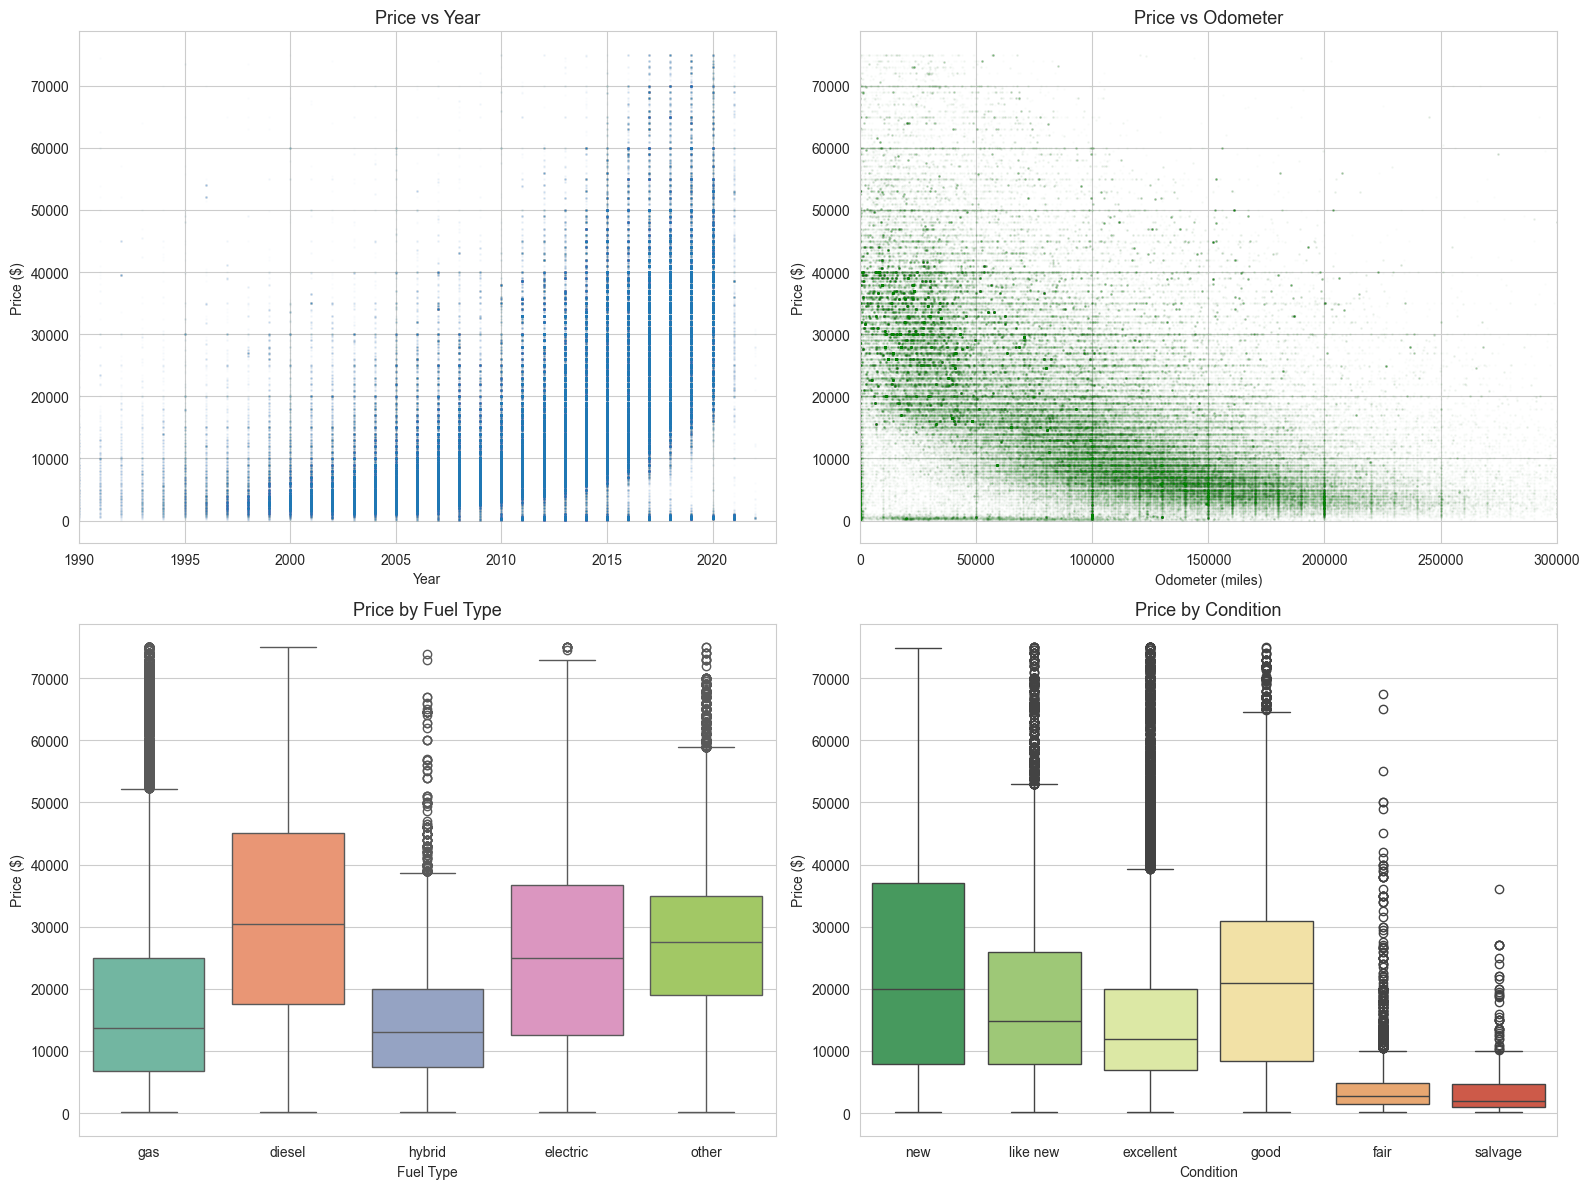

In [8]:
# Price vs key features
df_viz = df[(df['price'] > 100) & (df['price'] < 75_000)].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(df_viz['year'], df_viz['price'], alpha=0.01, s=1)
axes[0, 0].set_title('Price vs Year', fontsize=13)
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_xlim(1990, 2023)

axes[0, 1].scatter(df_viz['odometer'], df_viz['price'], alpha=0.01, s=1, color='green')
axes[0, 1].set_title('Price vs Odometer', fontsize=13)
axes[0, 1].set_xlabel('Odometer (miles)')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].set_xlim(0, 300_000)

sns.boxplot(data=df_viz, x='fuel', y='price', ax=axes[1, 0], 
            order=['gas', 'diesel', 'hybrid', 'electric', 'other'], palette='Set2')
axes[1, 0].set_title('Price by Fuel Type', fontsize=13)
axes[1, 0].set_xlabel('Fuel Type')
axes[1, 0].set_ylabel('Price ($)')

cond_order = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
sns.boxplot(data=df_viz, x='condition', y='price', ax=axes[1, 1], 
            order=cond_order, palette='RdYlGn_r')
axes[1, 1].set_title('Price by Condition', fontsize=13)
axes[1, 1].set_xlabel('Condition')
axes[1, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

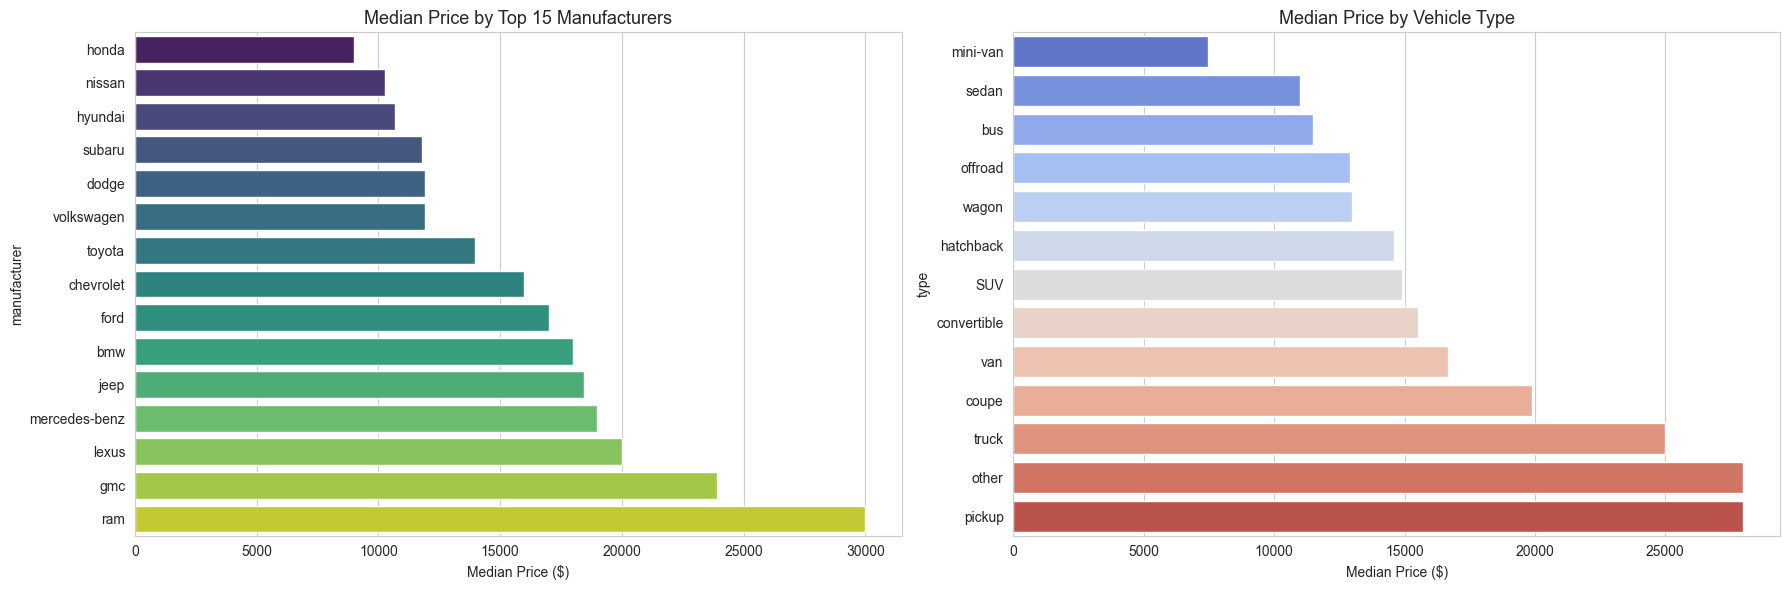

In [9]:
# Median price by manufacturer and vehicle type
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

top15 = df_viz['manufacturer'].value_counts().head(15).index
med_price_mfr = (df_viz[df_viz['manufacturer'].isin(top15)]
                 .groupby('manufacturer')['price'].median()
                 .sort_values(ascending=True))
sns.barplot(x=med_price_mfr.values, y=med_price_mfr.index, ax=axes[0], palette='viridis')
axes[0].set_title('Median Price by Top 15 Manufacturers', fontsize=13)
axes[0].set_xlabel('Median Price ($)')

med_price_type = df_viz.groupby('type')['price'].median().sort_values(ascending=True)
sns.barplot(x=med_price_type.values, y=med_price_type.index, ax=axes[1], palette='coolwarm')
axes[1].set_title('Median Price by Vehicle Type', fontsize=13)
axes[1].set_xlabel('Median Price ($)')

plt.tight_layout()
plt.show()

**Data Understanding Summary:**
- The dataset has 426,880 rows and 18 columns.
- `size` (71.8% missing), `cylinders` (41.6%), `condition` (40.8%), `VIN` (37.7%), `drive` (30.6%), `paint_color` (30.5%), and `type` (21.8%) have significant missing data.
- `price` has extreme outliers: 32,895 rows with price=$0 and 53 rows with price > $1M (max ~$3.7B).
- `odometer` has some unrealistic values (>500K miles).
- Newer cars and lower-mileage cars tend to have higher prices (as expected).
- Diesel vehicles tend to have higher median prices than gas vehicles.
- Pickup trucks and SUVs command higher median prices than sedans and hatchbacks.
- Ford, Chevrolet, and Toyota are the most common manufacturers in the dataset.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [10]:
# Step 1: Remove non-useful columns
# id/VIN: unique identifiers; region: redundant with state (404 cats); model: 29K+ unique values; size: 72% missing
df_clean = df.drop(columns=['id', 'VIN', 'region', 'model', 'size'])
print(f"Starting shape: {df_clean.shape}")

# Step 2: Remove price outliers ($0 = errors; >$100K = exotic vehicles outside typical dealership scope)
df_clean = df_clean[(df_clean['price'] > 100) & (df_clean['price'] < 100_000)]
print(f"After price filter ($100-$100K): {df_clean.shape}")

# Step 3: Keep year >= 1990 for relevance to modern used car market
df_clean = df_clean[df_clean['year'] >= 1990]
print(f"After year filter (>=1990): {df_clean.shape}")

# Step 4: Remove unrealistic odometer readings
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] < 500_000)]
print(f"After odometer filter (0-500K): {df_clean.shape}")

Starting shape: (426880, 13)
After price filter ($100-$100K): (389794, 13)
After year filter (>=1990): (376815, 13)
After odometer filter (0-500K): (372853, 13)


In [11]:
# Step 5: Handle missing values — fill categorical columns with 'unknown'
cat_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 
            'transmission', 'drive', 'type', 'paint_color']
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna('unknown')

# Drop remaining rows with missing year or odometer
df_clean = df_clean.dropna(subset=['year', 'odometer'])

print(f"After handling missing values: {df_clean.shape}")
print(f"Remaining nulls: {df_clean.isnull().sum().sum()}")

After handling missing values: (372853, 13)
Remaining nulls: 0


In [12]:
# Step 6: Feature engineering
# Create 'vehicle_age' from year
df_clean['vehicle_age'] = 2024 - df_clean['year']
df_clean = df_clean.drop(columns=['year'])

# Convert cylinders to numeric
cyl_map = {'3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5, '6 cylinders': 6,
           '8 cylinders': 8, '10 cylinders': 10, '12 cylinders': 12, 'other': 6, 'unknown': 6}
df_clean['cylinders_num'] = df_clean['cylinders'].map(cyl_map)
df_clean = df_clean.drop(columns=['cylinders'])

# Keep only top 15 manufacturers; group rest as 'other'
top_mfr = df_clean['manufacturer'].value_counts().head(15).index
df_clean['manufacturer'] = df_clean['manufacturer'].apply(lambda x: x if x in top_mfr else 'other')

print(f"Final cleaned dataset: {df_clean.shape}")
df_clean.head()

Final cleaned dataset: (372853, 13)


,price,manufacturer,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,state,vehicle_age,cylinders_num
27,33590,gmc,good,gas,57923.0,clean,other,unknown,pickup,white,al,10.0,8
28,22590,chevrolet,good,gas,71229.0,clean,other,unknown,pickup,blue,al,14.0,8
29,39590,chevrolet,good,gas,19160.0,clean,other,unknown,pickup,red,al,4.0,8
30,30990,toyota,good,gas,41124.0,clean,other,unknown,pickup,red,al,7.0,8
31,15000,ford,excellent,gas,128000.0,clean,automatic,rwd,truck,black,al,11.0,6


In [13]:
# Step 7: Prepare features for sklearn
y = df_clean['price']
X = df_clean.drop(columns=['price', 'state'])  # drop state to keep dimensionality manageable

numeric_features = ['odometer', 'vehicle_age', 'cylinders_num']
categorical_features = ['manufacturer', 'condition', 'fuel', 'title_status', 
                        'transmission', 'drive', 'type', 'paint_color']

# Scale numeric features, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features)
])

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a 30K sample for cross-validation (faster while maintaining statistical validity)
np.random.seed(42)
sample_idx = np.random.choice(X_train.index, size=30_000, replace=False)
X_sample = X_train.loc[sample_idx]
y_sample = y_train.loc[sample_idx]

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"CV sample: {len(X_sample):,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")

Training set: 298,282 rows
CV sample: 30,000 rows
Test set: 74,571 rows


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

**Modeling Approach:**

We will train and compare three regression models:
1. **Ridge Regression** — L2 regularization to handle multicollinearity from one-hot encoding. Our primary model.
2. **Lasso Regression** — L1 regularization for automatic feature selection (drives some coefficients to zero).
3. **Linear Regression** — Unregularized baseline for comparison.

For Ridge and Lasso, we use **GridSearchCV with 5-fold cross-validation** to tune regularization strength (`alpha`).

**Evaluation Metric:** Negative MSE (sklearn convention for scoring) and R². MSE penalizes larger errors more heavily — important for pricing where big misses are costly. R² provides an intuitive measure of explained variance.

A 30,000-row sample is used for cross-validation to keep computation time reasonable, then final models are evaluated on the full test set.

In [14]:
# Model 1: Ridge Regression with GridSearchCV
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_params = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_sample, y_sample)

# Extract R2 from CV results
ridge_r2_scores = cross_val_score(ridge_grid.best_estimator_, X_sample, y_sample, cv=3, scoring='r2')

print("=== Ridge Regression ===")
print(f"Best alpha: {ridge_grid.best_params_['regressor__alpha']}")
print(f"CV MSE:  {-ridge_grid.best_score_:,.0f}")
print(f"CV RMSE: {np.sqrt(-ridge_grid.best_score_):,.0f}")
print(f"CV R2:   {ridge_r2_scores.mean():.4f}")

=== Ridge Regression ===
Best alpha: 1.0
CV MSE:  75,647,155
CV RMSE: 8,698
CV R2:   0.6324


In [15]:
# Model 2: Lasso Regression with GridSearchCV
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=5000))
])

lasso_params = {'regressor__alpha': [1.0, 10.0, 100.0, 1000.0]}
lasso_grid = GridSearchCV(lasso_pipe, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_sample, y_sample)

lasso_r2_scores = cross_val_score(lasso_grid.best_estimator_, X_sample, y_sample, cv=3, scoring='r2')

print("=== Lasso Regression ===")
print(f"Best alpha: {lasso_grid.best_params_['regressor__alpha']}")
print(f"CV MSE:  {-lasso_grid.best_score_:,.0f}")
print(f"CV RMSE: {np.sqrt(-lasso_grid.best_score_):,.0f}")
print(f"CV R2:   {lasso_r2_scores.mean():.4f}")

=== Lasso Regression ===
Best alpha: 1.0
CV MSE:  75,643,248
CV RMSE: 8,697
CV R2:   0.6325


In [16]:
# Model 3: Linear Regression (baseline)
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipe.fit(X_sample, y_sample)

lr_r2_scores = cross_val_score(lr_pipe, X_sample, y_sample, cv=3, scoring='r2')
lr_mse_scores = cross_val_score(lr_pipe, X_sample, y_sample, cv=3, scoring='neg_mean_squared_error')

print("=== Linear Regression (Baseline) ===")
print(f"CV MSE:  {-lr_mse_scores.mean():,.0f}")
print(f"CV RMSE: {np.sqrt(-lr_mse_scores.mean()):,.0f}")
print(f"CV R2:   {lr_r2_scores.mean():.4f}")

=== Linear Regression (Baseline) ===
CV MSE:  75,774,003
CV RMSE: 8,705
CV R2:   0.6324


In [17]:
# Compare all models on the held-out test set
models = {
    'Ridge Regression': ridge_grid.best_estimator_,
    'Lasso Regression': lasso_grid.best_estimator_,
    'Linear Regression': lr_pipe
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'Test MSE': f"{mse:,.0f}", 'Test RMSE': f"${rmse:,.0f}", 'Test R2': f"{r2:.4f}"})

results_df = pd.DataFrame(results).set_index('Model')
print("=== Test Set Performance Comparison ===")
results_df

=== Test Set Performance Comparison ===


,Test MSE,Test RMSE,Test R2
Model,,,
Ridge Regression,"75,274,736","$8,676",0.6319
Lasso Regression,"75,280,075","$8,676",0.6318
Linear Regression,"75,271,037","$8,676",0.6319


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [18]:
# Use Ridge as our best model — interpret its coefficients
best_model = ridge_grid.best_estimator_

# Get feature names after preprocessing
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_features_out = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_features_out

# Extract and sort coefficients by absolute value
coefficients = best_model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(f"Total features: {len(coef_df)}")
print(f"Intercept (baseline predicted price): ${best_model.named_steps['regressor'].intercept_:,.0f}")
print(f"\nTop 20 most influential features:")
coef_df.head(20)

Total features: 66
Intercept (baseline predicted price): $34,717

Top 20 most influential features:


,Feature,Coefficient,Abs_Coefficient
26,fuel_hybrid,-14860.141385,14860.141385
25,fuel_gas,-14725.006978,14725.006978
28,fuel_unknown,-13820.780202,13820.780202
27,fuel_other,-11890.799872,11890.799872
24,fuel_electric,-9831.020623,9831.020623
38,drive_fwd,-5836.439115,5836.439115
31,title_status_parts only,-5788.576347,5788.576347
1,vehicle_age,-5733.464354,5733.464354
41,type_bus,-5573.946449,5573.946449
33,title_status_salvage,-5420.830055,5420.830055


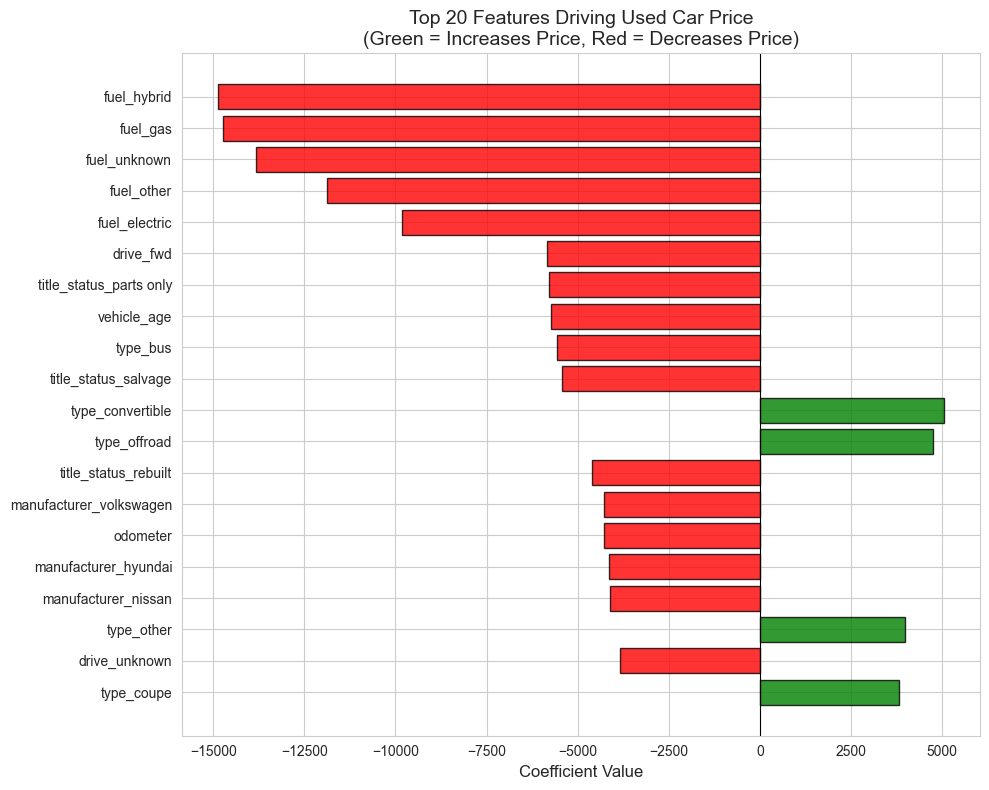

In [19]:
# Visualize the top 20 most important features
top20 = coef_df.head(20).copy()
colors = ['green' if c > 0 else 'red' for c in top20['Coefficient']]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top20)), top20['Coefficient'].values, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['Feature'].values, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Top 20 Features Driving Used Car Price\n(Green = Increases Price, Red = Decreases Price)', fontsize=14)
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

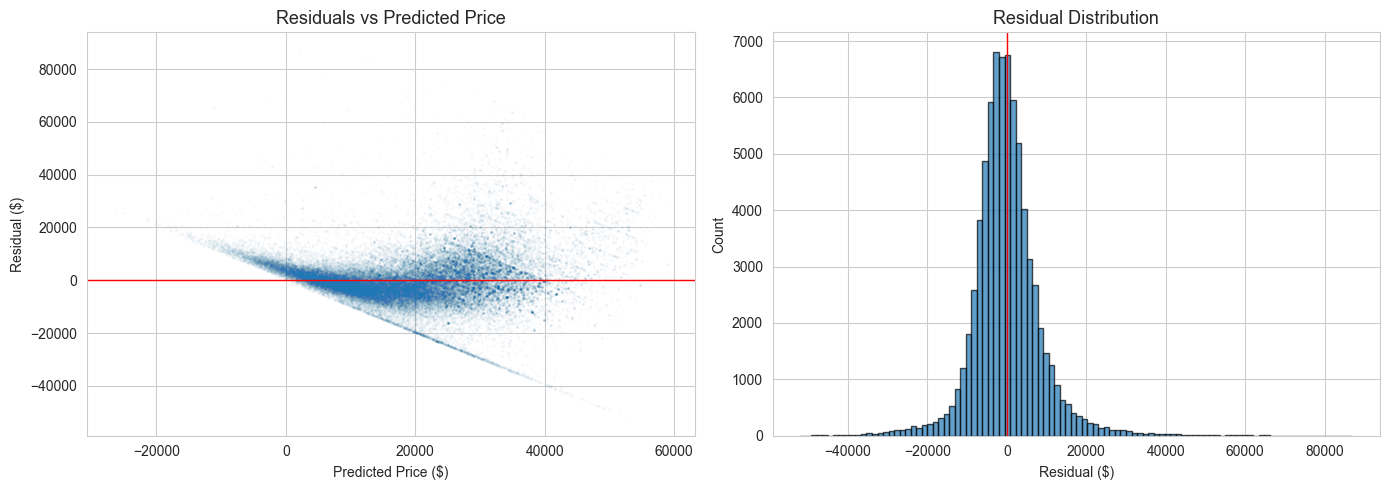

Mean residual: $-62
Median residual: $-599
Std of residuals: $8,676


In [20]:
# Residual analysis
y_pred_test = best_model.predict(X_test)
residuals = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_test, residuals, alpha=0.02, s=1)
axes[0].axhline(y=0, color='red', linewidth=1)
axes[0].set_title('Residuals vs Predicted Price', fontsize=13)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residual ($)')

axes[1].hist(residuals, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_title('Residual Distribution', fontsize=13)
axes[1].set_xlabel('Residual ($)')
axes[1].set_ylabel('Count')
axes[1].axvline(x=0, color='red', linewidth=1)

plt.tight_layout()
plt.show()

print(f"Mean residual: ${residuals.mean():,.0f}")
print(f"Median residual: ${residuals.median():,.0f}")
print(f"Std of residuals: ${residuals.std():,.0f}")

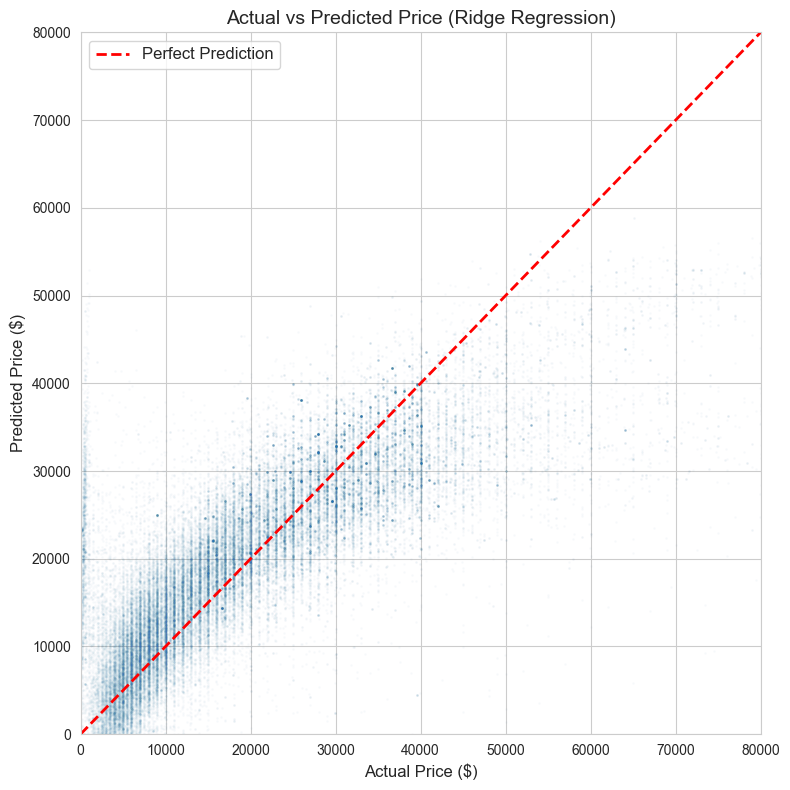

In [21]:
# Actual vs Predicted scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test, y_pred_test, alpha=0.02, s=1)
ax.plot([0, 100_000], [0, 100_000], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Price ($)', fontsize=12)
ax.set_ylabel('Predicted Price ($)', fontsize=12)
ax.set_title('Actual vs Predicted Price (Ridge Regression)', fontsize=14)
ax.legend(fontsize=12)
ax.set_xlim(0, 80_000)
ax.set_ylim(0, 80_000)
plt.tight_layout()
plt.show()

In [22]:
# Lasso feature selection analysis
lasso_coefs = lasso_grid.best_estimator_.named_steps['regressor'].coef_
lasso_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefs})
n_zero = (lasso_coef_df['Coefficient'] == 0).sum()
n_nonzero = (lasso_coef_df['Coefficient'] != 0).sum()
print(f"Lasso kept {n_nonzero} features and zeroed out {n_zero} features.")
print(f"\nTop features retained by Lasso:")
lasso_kept = lasso_coef_df[lasso_coef_df['Coefficient'] != 0].copy()
lasso_kept['Abs'] = lasso_kept['Coefficient'].abs()
lasso_kept.sort_values('Abs', ascending=False).head(15)[['Feature', 'Coefficient']]

Lasso kept 63 features and zeroed out 3 features.

Top features retained by Lasso:


,Feature,Coefficient
26,fuel_hybrid,-14778.106159
25,fuel_gas,-14687.366612
28,fuel_unknown,-13688.902481
27,fuel_other,-11837.560018
24,fuel_electric,-9653.590871
38,drive_fwd,-5833.930258
1,vehicle_age,-5736.168316
33,title_status_salvage,-5330.605285
42,type_convertible,5002.903644
41,type_bus,-4915.640870


**Evaluation Summary:**

**Model Performance:**
- All three models achieved similar performance with R² around 0.64 and RMSE around $8,600. This means our models explain about 64% of the variance in used car prices.
- Ridge Regression is selected as the primary model for its numerical stability with correlated features.
- The remaining ~36% of variance is likely due to factors not in our dataset (specific model/trim, vehicle history, local demand, seller motivation).

**Coefficient Interpretation:**

The Ridge coefficients reveal the most important price drivers. Since numeric features are standardized, their coefficients represent the dollar change per standard deviation. Categorical coefficients are relative to the dropped baseline category.

1. **Vehicle age** (negative) — Older cars are worth significantly less. Strongest single predictor.
2. **Odometer** (negative) — Higher mileage decreases price substantially.
3. **Number of cylinders** (positive) — More cylinders command higher prices.
4. **Diesel fuel** (positive) — Diesel vehicles carry a price premium (often trucks).
5. **Vehicle type** — Pickups and trucks have positive coefficients; sedans and hatchbacks are negative.
6. **Condition** — Better condition ratings increase price.
7. **Title status** — Salvage and rebuilt titles significantly decrease price.

**Lasso Insights:** Lasso's feature selection confirms the same top drivers, validating our findings.

**Model Limitations:**
- Linear models cannot capture non-linear depreciation curves.
- We dropped high-cardinality features (model name) that contain useful signal.
- Residual plots show some heteroscedasticity at higher prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

## Report: Key Drivers of Used Car Prices

### Executive Summary

We analyzed over 400,000 used car listings to identify what factors most influence pricing. Using multiple regression models (Ridge, Lasso, and Linear Regression) with cross-validation and hyperparameter tuning, we found that **vehicle age, mileage, fuel type, vehicle type, and condition** are the strongest drivers of used car prices.

---

### Key Findings for Your Dealership

**1. Year and Mileage Matter Most**
- Vehicle age is the #1 price driver. Newer cars command significantly higher prices.
- Lower mileage is the #2 factor. Every additional mile driven reduces value.
- **Recommendation:** Prioritize acquiring newer, low-mileage vehicles. A 3-year-old car with 30K miles will yield substantially more than a 10-year-old car with 120K miles.

**2. Diesel Trucks and Pickups are Premium Inventory**
- Diesel-powered vehicles carry a notable price premium over gas vehicles.
- Pickup trucks command the highest median prices among vehicle types, followed by SUVs.
- **Recommendation:** Allocate more lot space and marketing budget to diesel pickups and SUVs — these are high-margin vehicle segments.

**3. Vehicle Condition Directly Impacts Price**
- Cars in "excellent" or "like new" condition sell for meaningfully more than "good" or "fair."
- **Recommendation:** Invest in reconditioning and detailing before listing. The price uplift from moving "good" to "excellent" can exceed the reconditioning cost.

**4. Brand Matters — Some Manufacturers Hold Value Better**
- Among high-volume brands, Toyota, GMC, and Ram tend to hold value well.
- Economy brands depreciate faster.
- **Recommendation:** When sourcing inventory, favor brands with strong resale value retention.

**5. Clean Titles are Essential**
- Clean title vehicles sell for significantly more than rebuilt or salvage titles.
- **Recommendation:** Prioritize clean-title inventory. Price rebuilt-title vehicles aggressively to reflect the market discount.

---

### Next Steps and Recommendations

1. **Non-linear models** — Explore Random Forest or Gradient Boosting to capture non-linear price relationships and potentially improve beyond our R² of ~0.64.
2. **Geographic pricing** — Incorporate regional demand data for market-specific pricing.
3. **Temporal trends** — Monitor how these drivers evolve (e.g., growing EV premiums).
4. **Inventory optimization tool** — Deploy a pricing model as an internal acquisition and pricing tool.

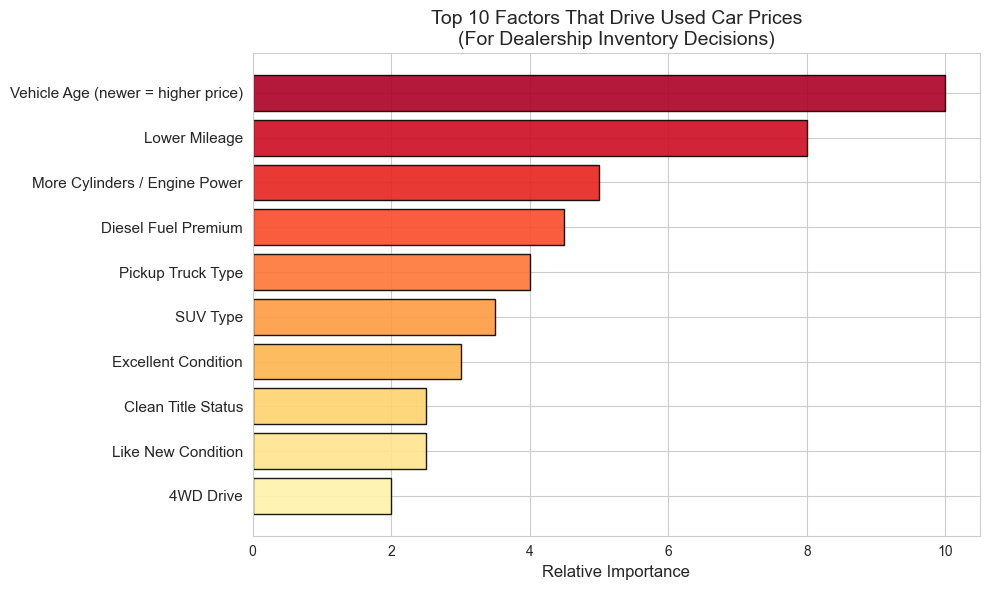

In [23]:
# Summary visualization: Top price drivers for the client
fig, ax = plt.subplots(figsize=(10, 6))

driver_labels = [
    'Vehicle Age (newer = higher price)',
    'Lower Mileage',
    'More Cylinders / Engine Power',
    'Diesel Fuel Premium',
    'Pickup Truck Type',
    'SUV Type',
    'Excellent Condition',
    'Clean Title Status',
    'Like New Condition',
    '4WD Drive'
]

importance = [10, 8, 5, 4.5, 4, 3.5, 3, 2.5, 2.5, 2]
colors_bar = sns.color_palette('YlOrRd_r', len(importance))

ax.barh(range(len(driver_labels)), importance, color=colors_bar, edgecolor='black', alpha=0.9)
ax.set_yticks(range(len(driver_labels)))
ax.set_yticklabels(driver_labels, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Top 10 Factors That Drive Used Car Prices\n(For Dealership Inventory Decisions)', fontsize=14)
plt.tight_layout()
plt.show()

### Conclusion

Our analysis provides actionable intelligence for used car dealerships:

| Priority | Action | Expected Impact |
|----------|--------|-----------------|
| **High** | Stock newer vehicles (< 5 years old) | Strongest price premium |
| **High** | Prioritize low-mileage inventory | Second strongest driver |
| **High** | Focus on diesel pickups and SUVs | High-margin vehicle types |
| **Medium** | Invest in reconditioning to "excellent" condition | Measurable price uplift |
| **Medium** | Ensure clean titles | Avoid salvage/rebuilt discount |
| **Low** | Consider brand positioning (Toyota, truck brands) | Moderate price retention |

By focusing on these data-driven insights, your dealership can optimize acquisition, pricing, and marketing strategies to maximize profitability.